In [2]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

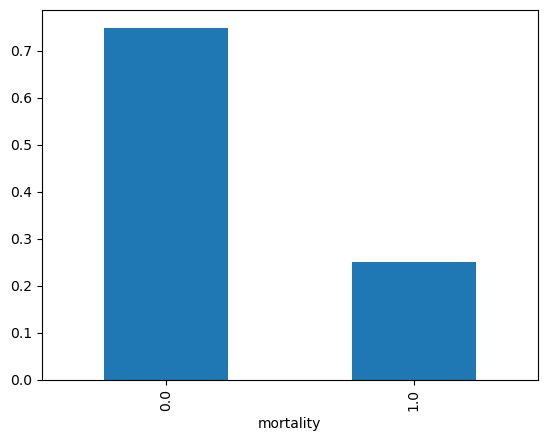

In [13]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

<Axes: xlabel='mortality', ylabel='count'>

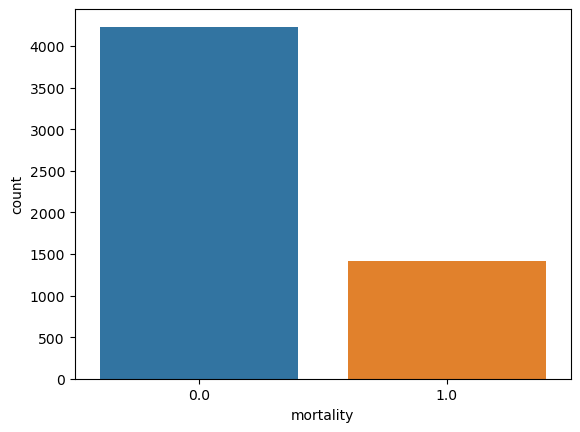